Checking memory usage for adj_list object in umi_tools

One of the issues with very deep sequenced samples when using UMI-tools is that some positions are covered so deeply that the possible UMIs are almost saturated. 

We would like to raise an warning when this happens.

In addition, this causes memory issues and run time issues when the UMI length is long. We would like to know what combination of UMI length and proportion of UMIs observed leads to excessive memory usage and long run times. 

In [1]:
%load_ext rpy2.ipython
%matplotlib inline  

In [2]:
import sys

def get_size(obj, seen=None):
    """Recursively finds size of objects"""
    size = sys.getsizeof(obj)
    if seen is None:
        seen = set()
    obj_id = id(obj)
    if obj_id in seen:
        return 0
    # Important mark as seen *before* entering recursion to gracefully handle
    # self-referential objects
    seen.add(obj_id)
    if isinstance(obj, dict):
        size += sum([get_size(v, seen) for v in obj.values()])
        size += sum([get_size(k, seen) for k in obj.keys()])
    elif hasattr(obj, '__dict__'):
        size += get_size(obj.__dict__, seen)
    elif hasattr(obj, '__iter__') and not isinstance(obj, (str, bytes, bytearray)):
        size += sum([get_size(i, seen) for i in obj])
    return size

In [1]:
import random
import pandas as pd
import numpy as np
import pyximport
import itertools
pyximport.install(reload_support=True)
from umi_tools._dedup_umi import edit_distance

In [4]:
def getRandomUMI(length):
    UMI = ""
    bases = ["A", "C", "T", "G"]
    for base in range(0, length):
        UMI += random.choice(bases)
        
    return(bytes(UMI, encoding="UTF-8"))
        
def getAllUMIs(length):
    return ["".join(x) for x in itertools.product('ACTG', repeat=length)]

def getRandomUMIs(n, UMI_length):
    UMIs = set()
    if n < 0.1 * (4**UMI_length):
        for umi_ix in range(0, n):
            while True:
                UMI = getRandomUMI(UMI_length)
                if UMI not in UMIs:
                    UMIs.add(UMI)
                    break
    else:
        UMIs = np.random.choice(getAllUMIs(UMI_length), n, replace=False)
        UMIs = set([bytes(UMI, encoding="UTF-8") for UMI in UMIs])
    
    return(UMIs)

x = getRandomUMIs(100, 5)

print(len(x))

    

100


In [5]:
def get_adj_list_adjacency(umis, threshold=1):
    ''' identify all umis within hamming distance threshold'''

    adj_list = {umi: [] for umi in umis}
    for umi1, umi2 in itertools.combinations(umis, 2):
        if edit_distance(umi1, umi2) <= threshold:
            adj_list[umi1].append(umi2)
            adj_list[umi2].append(umi1)

    return adj_list

In [6]:
x = getRandomUMIs(100, 5)
adj_list = get_adj_list_adjacency(x)
adj_list_size = get_size(adj_list)
print(adj_list_size)

18936


In [7]:
rows = []

for umi_length in range(4, 10):
    possible_umis = 4**umi_length
    for depth in range(-10,-2):
        fraction_possible_umis = 2**depth
        number_of_UMis = round(fraction_possible_umis * possible_umis)
        
        UMIs = getRandomUMIs(number_of_UMis, umi_length)
        adj_list = get_adj_list_adjacency(UMIs)
        adj_list_size = get_size(adj_list)
        rows.append([umi_length, fraction_possible_umis, number_of_UMis, adj_list_size])
        

In [8]:
print(len(rows))
df = pd.DataFrame.from_records(rows, columns=["UMI_length", "Saturation", "number_umis", "adj_list_size"])
print(df.head())

48
   UMI_length  Saturation  number_umis  adj_list_size
0           4    0.000977            0            288
1           4    0.001953            0            288
2           4    0.003906            1            389
3           4    0.007812            2            490
4           4    0.015625            4            692


In [9]:
%%R
library(ggplot2)


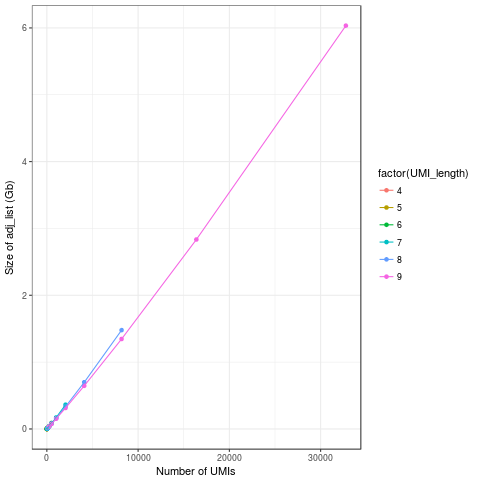

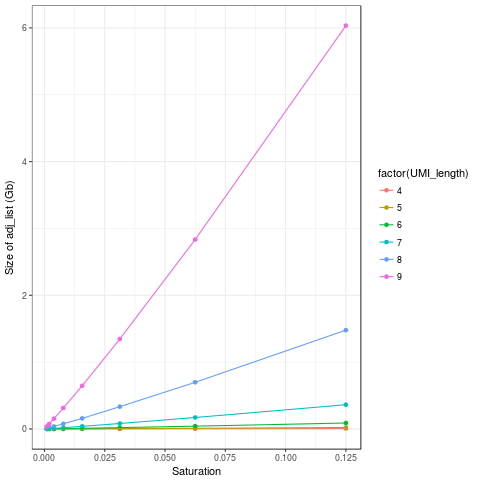

In [10]:
%%R -i df

p <- ggplot(df, aes(number_umis, adj_list_size/(1024^2), colour=factor(UMI_length), group=UMI_length)) +
geom_point() + geom_line() + theme_bw() + xlab("Number of UMIs") + ylab("Size of adj_list (Gb)")

print(p)

p <- ggplot(df, aes(Saturation, adj_list_size/(1024^2), colour=factor(UMI_length), group=UMI_length)) +
geom_point() + geom_line() + theme_bw() + xlab("Saturation") + ylab("Size of adj_list (Gb)")

print(p)

In [11]:
%%R

fit = lm(formula=I(adj_list_size-288) ~ 0 + number_umis+UMI_length, data=df)
print(summary(fit))

fit = lm(formula=I(adj_list_size-288) ~ 0 + number_umis*UMI_length, data=df)
print(summary(fit))


Call:
lm(formula = I(adj_list_size - 288) ~ 0 + number_umis + UMI_length, 
    data = df)

Residuals:
    Min      1Q  Median      3Q     Max 
-125983    8459   11367   13936  107198 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
number_umis   190.547      1.002 190.110  < 2e-16 ***
UMI_length  -2684.801    841.198  -3.192  0.00255 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 35640 on 46 degrees of freedom
Multiple R-squared:  0.9989,	Adjusted R-squared:  0.9989 
F-statistic: 2.152e+04 on 2 and 46 DF,  p-value: < 2.2e-16


Call:
lm(formula = I(adj_list_size - 288) ~ 0 + number_umis * UMI_length, 
    data = df)

Residuals:
    Min      1Q  Median      3Q     Max 
-125276    6751   11136   14152  108123 

Coefficients:
                         Estimate Std. Error t value Pr(>|t|)    
number_umis              195.9537    33.3852   5.869 4.88e-07 ***
UMI_length             -2739.1770   914.0837  -2.997  0.00443 **

In [12]:
def predictSizeOfAdjList(number_UMIs, UMI_length):
    return 288 + (number_UMIs * 197.9464) - (2682.068 * UMI_length)


def predictSizeOfAdjList(number_UMIs, UMI_length):
    return 288 + (number_UMIs * 197.9464) - (2756.4888 * UMI_length) - (0.8242 * number_UMIs * UMI_length)


predictSizeOfAdjList(2000, 5)

374156.356

In [13]:
predictSizeOfAdjList(100000, 20) / (1024*1024)

17.253301834106445

In [14]:
predict_rows = []

for umi_length in range(4, 12):
    possible_umis = 4**umi_length
    for depth in range(-10,-1):
        fraction_possible_umis = 2**depth
        number_of_UMIs = round(fraction_possible_umis * possible_umis)
        
        pred_adj_list_size = predictSizeOfAdjList(number_of_UMIs, umi_length)
        predict_rows.append([umi_length, fraction_possible_umis, number_of_UMIs, pred_adj_list_size])

        
pred_df = pd.DataFrame.from_records(
    predict_rows, columns=["UMI_length", "Saturation", "number_umis", "adj_list_size"])

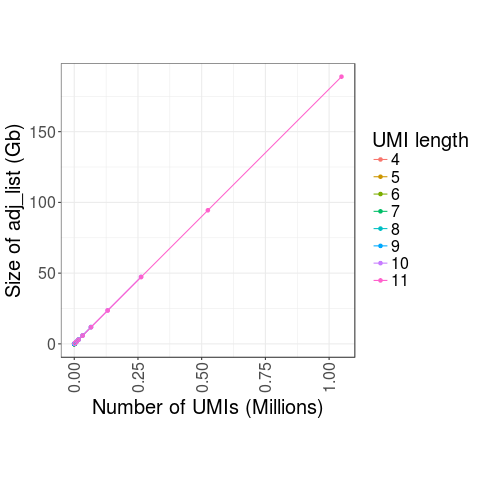

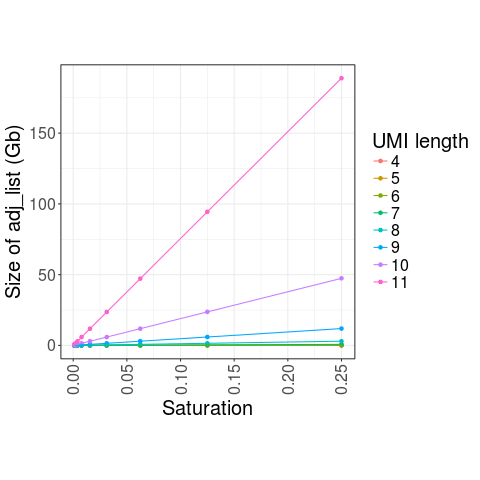

In [15]:
%%R -i pred_df

my_theme <- theme(text=element_text(size=20), aspect.ratio=1)

p <- ggplot(pred_df, aes(number_umis/1000000, adj_list_size/(1024^2),
                         colour=factor(UMI_length), group=UMI_length)) +
geom_point() + geom_line() + theme_bw() + xlab("Number of UMIs (Millions)") +
ylab("Size of adj_list (Gb)") + my_theme + theme(axis.text.x=element_text(angle=90, vjust=0.5, hjust=1)) +
scale_colour_discrete(name="UMI length")

p1 <- p

print(p1)

p2 <- p + aes(Saturation) + xlab("Saturation") + ylab("Size of adj_list (Gb)")

print(p2)

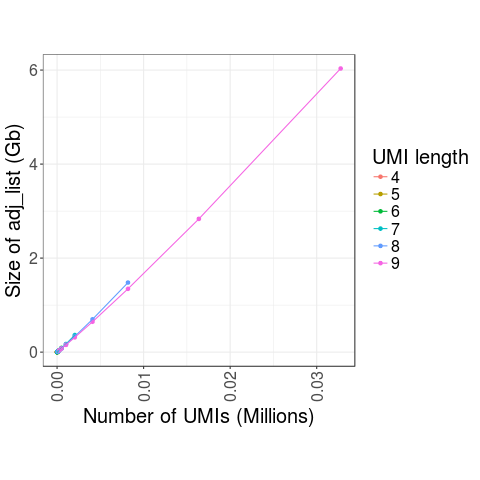

In [16]:
%%R
p_raw <- p1 %+% df
print(p_raw)

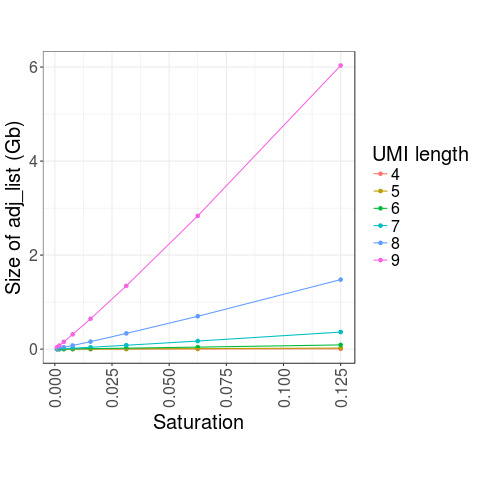

In [17]:
%%R
p_raw <- p2 %+% df
print(p_raw)

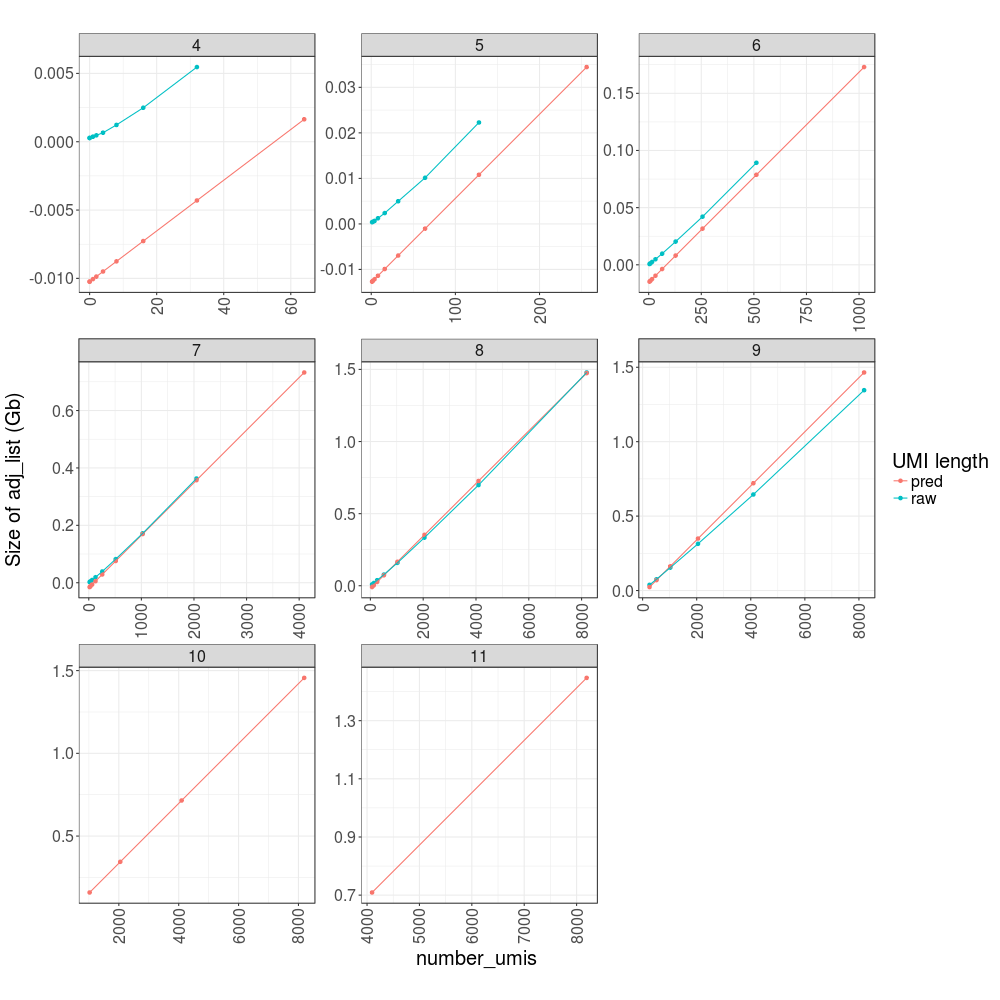

In [18]:
%%R -w 1000 -h 1000
df$type = "raw"
pred_df$type = "pred"

cat_df <- rbind(df, pred_df)
cat_df <- cat_df[cat_df$number_umis<10000,]

p_cat <- p1 %+% cat_df + aes(x=number_umis, colour=type, group=type) + facet_wrap(~UMI_length, scale='free')
print(p_cat)